In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


### Importing data

In [ ]:
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 99% 80.0M/80.9M [00:03<00:00, 33.1MB/s]
100% 80.9M/80.9M [00:03<00:00, 25.0MB/s]


In [ ]:
from zipfile import ZipFile
file_name = "/content/sentiment140.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print("Done")

Done


In [ ]:
import numpy as np
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score , confusion_matrix , classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
df = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1' , names = ["target" , "id" , "date" , "flag" , "user" , "text"] )

In [ ]:
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [ ]:
df.shape

(1600000, 6)

In [ ]:
df['target'].value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

In [ ]:
df.isnull().sum()

target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64

In [ ]:
df.duplicated().sum()

0

In [ ]:
for i in df.columns:
  if(df[i].nunique() == 1):
    print(i)

flag


In [ ]:
df.drop(columns = ['flag'], inplace = True)

In [ ]:
df['target'].replace({4:1},inplace=True)

In [ ]:
df['target'].value_counts()

target
0    800000
1    800000
Name: count, dtype: int64

In [ ]:
stemmer = PorterStemmer()

In [ ]:
def stemming(content):
  stemmed_content = re.sub('[^a-zA-Z]',' ',content)
  stemmed_content = stemmed_content.lower()
  stemmed_content = stemmed_content.split()
  stemmed_content = [stemmer.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
  stemmed_content = ' '.join(stemmed_content)
  return stemmed_content

In [ ]:
from nltk.tokenize import word_tokenize

In [ ]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)     # Remove mentions
    text = re.sub(r'#\w+', '', text)     # Remove hashtags
    text = re.sub(r'\d+', '', text)      # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()                  # Convert to lowercase
    text = word_tokenize(text)           # Tokenize
    text = [stemmer.stem(word) for word in text if word not in stopwords.words('english')]  # Remove stopwords
    return ' '.join(text)

In [ ]:
df['cleaned_review'] = df['text'].apply(clean_text)

In [ ]:
df['text_stemmed'] = df['text'].apply(stemming)

In [ ]:
df.head()

,target,id,date,user,text,cleaned_review,text_stemmed
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww that bummer shoulda got david carr third day,switchfoot http twitpic com zl awww bummer sho...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...,upset cant updat facebook text might cri resul...,upset updat facebook text might cri result sch...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...,dive mani time ball manag save rest go bound,kenichan dive mani time ball manag save rest g...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire,whole bodi feel itchi like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all....",behav im mad cant see,nationwideclass behav mad see


### word clouds for positive and negative reviews

In [ ]:
positive_reviews = df[df['target'] == 1]['cleaned_review'].str.cat(sep=' ')
negative_reviews = df[df['target'] == 0]['cleaned_review'].str.cat(sep=' ')

In [ ]:
positive_reviews1 = df[df['target'] == 1]['text_stemmed'].str.cat(sep=' ')
negative_reviews1 = df[df['target'] == 0]['text_stemmed'].str.cat(sep=' ')

In [ ]:
wordcloud_positive = WordCloud(width=800, height=400).generate(positive_reviews)
wordcloud_negative = WordCloud(width=800, height=400).generate(negative_reviews)

In [ ]:
wordcloud_positive1 = WordCloud(width=800, height=400).generate(positive_reviews1)
wordcloud_negative1 = WordCloud(width=800, height=400).generate(negative_reviews1)

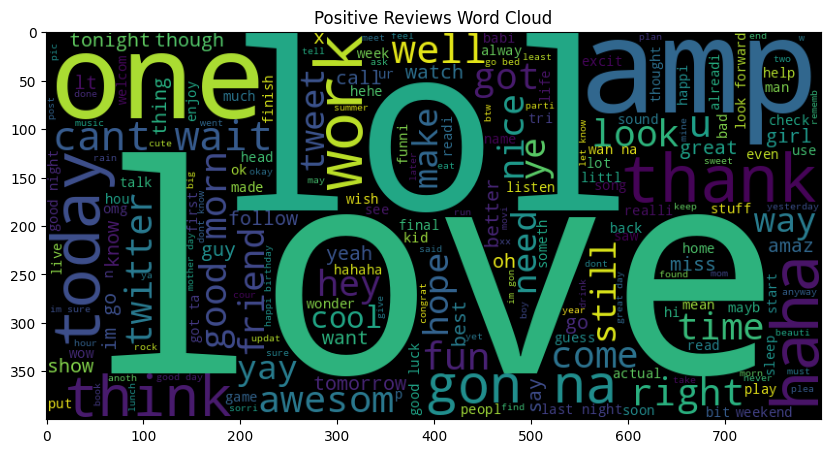

In [ ]:
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_positive)
plt.title('Positive Reviews Word Cloud')
plt.show()

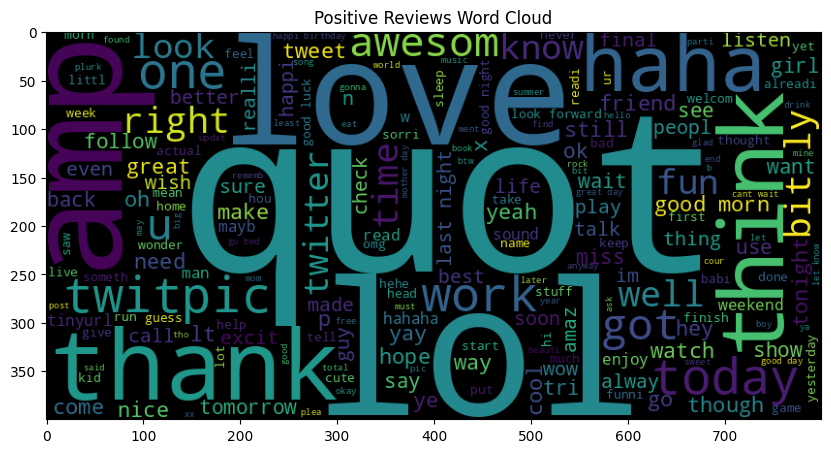

In [ ]:
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_positive1)
plt.title('Positive Reviews Word Cloud')
plt.show()

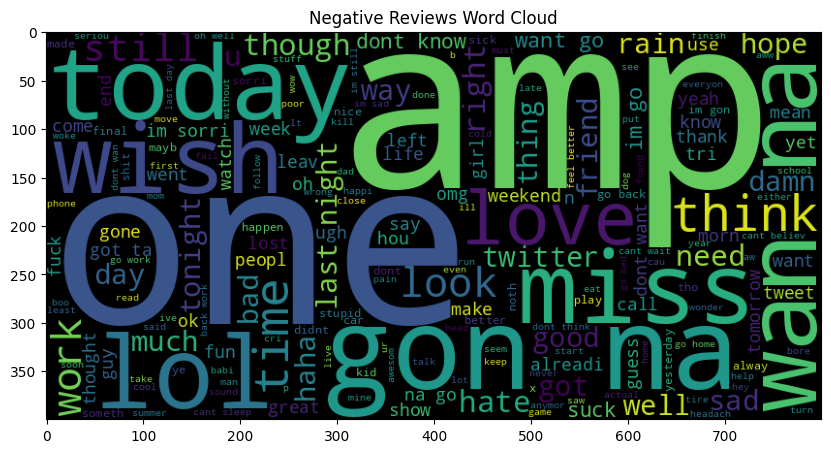

In [ ]:
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_negative)
plt.title('Negative Reviews Word Cloud')
plt.show()

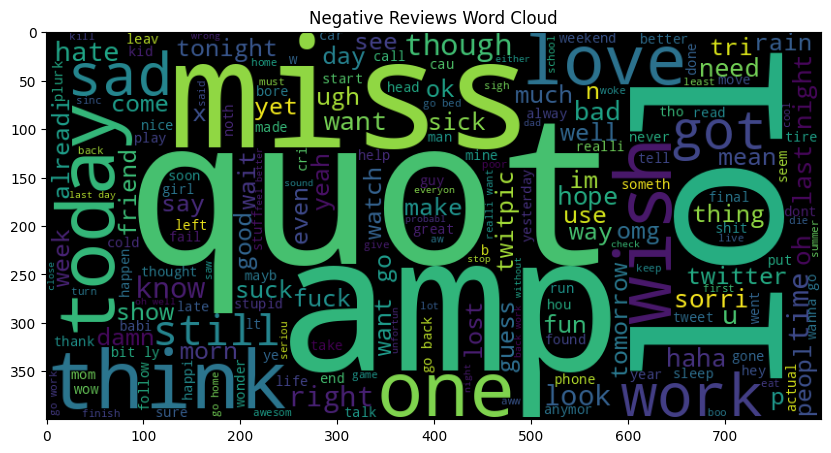

In [ ]:
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_negative1)
plt.title('Negative Reviews Word Cloud')
plt.show()

In [ ]:
X = df['text_stemmed']
Y = df['target']

In [ ]:
XX = df['cleaned_review']
YY = df['target']

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

In [ ]:
XX_train, XX_test, YY_train, YY_test = train_test_split(XX, YY, test_size=0.2, stratify=YY, random_state=42)

In [ ]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [ ]:
vectorizer = TfidfVectorizer()
XX_train = vectorizer.fit_transform(XX_train)
XX_test = vectorizer.transform(XX_test)

In [ ]:
lr = LogisticRegression(max_iter = 1000)
lr.fit(X_train, Y_train)

LogisticRegression(max_iter=1000)

In [ ]:
lr1= LogisticRegression(max_iter = 1000)
lr1.fit(XX_train, YY_train)

LogisticRegression(max_iter=1000)

In [ ]:
training_data_accuracy = accuracy_score(Y_train , lr.predict(X_train))
print('Accuracy score of training data : ', training_data_accuracy)

Accuracy score of training data :  0.81021171875


In [ ]:
test_data_accuracy = accuracy_score(Y_test , lr.predict(X_test))
print('Accuracy score of test data : ', test_data_accuracy)

Accuracy score of test data :  0.778690625


In [ ]:
print('Accuracy of training data', accuracy_score(YY_train , lr1.predict(XX_train)))

Accuracy of training data 0.80132890625


In [ ]:
print('Accuracy of test data', accuracy_score(YY_test , lr1.predict(XX_test)))

Accuracy of test data 0.77881875


In [ ]:
YY_pred = lr1.predict(XX_test)

In [ ]:
y_pred = lr.predict(X_test)

              precision    recall  f1-score   support

           0       0.79      0.76      0.77    160000
           1       0.77      0.80      0.78    160000

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



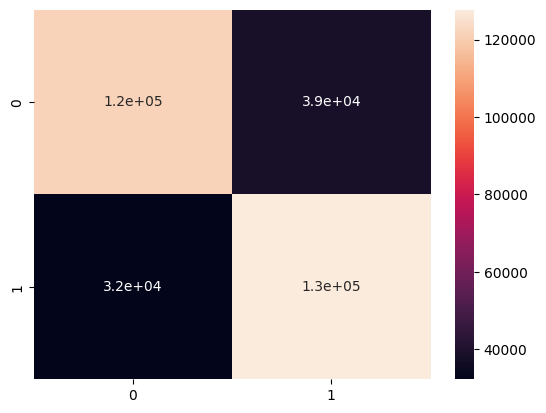

In [ ]:
print(classification_report(Y_test, y_pred))
conf_matrix = confusion_matrix(Y_test, y_pred)
sns.heatmap(conf_matrix, annot=True)
plt.show()

              precision    recall  f1-score   support

           0       0.79      0.76      0.77    160000
           1       0.77      0.80      0.78    160000

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



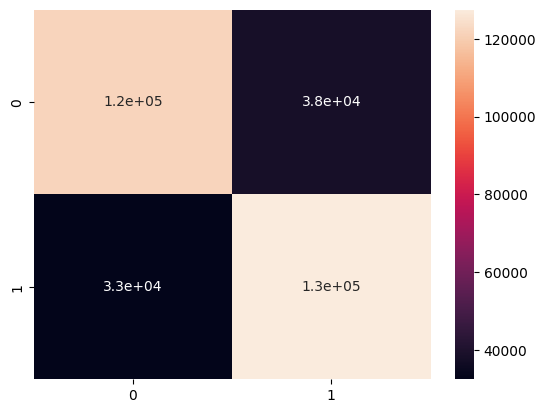

In [ ]:
print(classification_report(YY_test, YY_pred))
conf_matrix = confusion_matrix(YY_test, YY_pred)
sns.heatmap(conf_matrix, annot=True)
plt.show()

In [ ]:
def predict_sentiment(review, vectorizer, model):
    cleaned_review = clean_text(review)
    review_tfidf = vectorizer.transform([cleaned_review])
    sentiment = model.predict(review_tfidf)
    sentiment_label = 'Positive' if sentiment[0] == 1 else 'Negative'
    return sentiment_label

In [ ]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(lr, open(filename, 'wb'))

In [ ]:
# loading the saved model
loaded_model = pickle.load(open('/content/finalized_model.sav', 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)
X_new = X_test[133]
print(X_new)
print(Y_test[133])
prediction = loaded_model.predict(X_new)
print(prediction)
if (prediction[0]==0):
  print('negative')
elif (prediction[0]==1):
  print('positive')

0.778690625
  (0, 446034)	0.16301596080452355
  (0, 347414)	0.16701801823177256
  (0, 329551)	0.2627820340200326
  (0, 288241)	0.12738626635493241
  (0, 204244)	0.34804021716070316
  (0, 179491)	0.25875484105820096
  (0, 159868)	0.1665744908033666
  (0, 149233)	0.7617603674532092
  (0, 111209)	0.2532531162852314
0
[0]
negative


In [ ]:
new_review = "This product is amazing! I love it."
predicted_sentiment = predict_sentiment(new_review, vectorizer, lr1)
print(f"The sentiment of the review is: {predicted_sentiment}")

The sentiment of the review is: Positive
